# Hypothesis Testing

In [1]:
import pandas as pd
import numpy as np
import feather

from scipy.stats import norm
from statsmodels.stats.proportion import proportions_ztest
import pingouin
from scipy.stats import chisquare

import matplotlib.pyplot as plt

In [2]:
stack_overflow = pd.read_feather('stack_overflow.feather')

In [3]:
stack_overflow.head()

,respondent,main_branch,hobbyist,age,age_1st_code,age_first_code_cut,comp_freq,comp_total,converted_comp,country,...,survey_length,trans,undergrad_major,webframe_desire_next_year,webframe_worked_with,welcome_change,work_week_hrs,years_code,years_code_pro,age_cat
0,36.0,"I am not primarily a developer, but I write co...",Yes,34.0,30.0,adult,Yearly,60000.0,77556.0,United Kingdom,...,Appropriate in length,No,"Computer science, computer engineering, or sof...",Express;React.js,Express;React.js,Just as welcome now as I felt last year,40.0,4.0,3.0,At least 30
1,47.0,I am a developer by profession,Yes,53.0,10.0,child,Yearly,58000.0,74970.0,United Kingdom,...,Appropriate in length,No,"A natural science (such as biology, chemistry,...",Flask;Spring,Flask;Spring,Just as welcome now as I felt last year,40.0,43.0,28.0,At least 30
2,69.0,I am a developer by profession,Yes,25.0,12.0,child,Yearly,550000.0,594539.0,France,...,Too short,No,"Computer science, computer engineering, or sof...",Django;Flask,Django;Flask,Just as welcome now as I felt last year,40.0,13.0,3.0,Under 30
3,125.0,"I am not primarily a developer, but I write co...",Yes,41.0,30.0,adult,Monthly,200000.0,2000000.0,United States,...,Appropriate in length,No,None,None,None,Just as welcome now as I felt last year,40.0,11.0,11.0,At least 30
4,147.0,"I am not primarily a developer, but I write co...",No,28.0,15.0,adult,Yearly,50000.0,37816.0,Canada,...,Appropriate in length,No,"Another engineering discipline (such as civil,...",None,Express;Flask,Just as welcome now as I felt last year,40.0,5.0,3.0,Under 30


## Z-score
$$z = \frac{sample\ statistic - hypoth.param.value}{standard\ error}$$
- standard error: standard deviation of the bootstrap distribution
- sample statistic: sample proportion
- hypoth.param.value: hypothesized progortion of population

### Z-score and p-value for one-sample proportion test

In [4]:
stack_overflow['age_cat'].value_counts(normalize=True)

Under 30       0.535604
At least 30    0.464396
Name: age_cat, dtype: float64

In [5]:
alpha = 0.01
p_hat = (stack_overflow['age_cat']=='Under 30').mean()
print(f'significance level: {alpha}, sample proportion: {p_hat}')

significance level: 0.01, sample proportion: 0.5356037151702786


In [6]:
p_0 = 0.5
print(f'hypothesized proportion of population: {p_0}')

hypothesized proportion of population: 0.5


In [7]:
n = len(stack_overflow)
print(f'sample size: {n}')

sample size: 2261


In [8]:
numerator = p_hat - p_0
denominator = np.sqrt(p_0*(1-p_0)/n)
z_score = numerator/denominator
print(f'Z-score: {z_score}')

Z-score: 3.385911440783663


In [9]:
p_value = 1- norm.cdf(z_score)
print(f'p-value for right-tailed test: {p_value}')
print(f'More participants under 30 than at least 30? {p_value < p_0}')

p-value for right-tailed test: 0.00035471136840503625
More participants under 30 than at least 30? True


In [10]:
p_value_two_tailed = 2*(1-norm.cdf(z_score)) # = norm.cdf(-z_score) + 1-norm.cdf(z_score)
print(f'p-value for two-tailed test: {p_value_two_tailed}')
print(f'Number of participants under 30 and at least 30 are not equal? {p_value_two_tailed < p_0}')

p-value for two-tailed test: 0.0007094227368100725
Number of participants under 30 and at least 30 are not equal? True


### Z-score and p-value for two-sample proportion test

#### Method 1: step-by-step

In [11]:
p_hats = stack_overflow.groupby('age_cat')['hobbyist'].value_counts(normalize=True)
p_hat_at_least_30 = p_hats[("At least 30", "Yes")]
p_hat_under_30 = p_hats[("Under 30", "Yes")]
print(f'Sample proportion: ≥30: {p_hat_at_least_30}, <30: {p_hat_under_30}')

Sample proportion: ≥30: 0.7733333333333333, <30: 0.8431048720066061


In [12]:
n = stack_overflow.groupby('age_cat')['hobbyist'].count()
n_at_least_30 = n["At least 30"]
n_under_30 = n["Under 30"]
print(f'Sample size: ≥30: {n_at_least_30}, <30: {n_under_30}')

Sample size: ≥30: 1050, <30: 1211


In [13]:
# Calculate the pooled estimate of the population proportion
p_hat = (n_at_least_30*p_hat_at_least_30 + n_under_30*p_hat_under_30)/(n_at_least_30+n_under_30)

std_error = np.sqrt(p_hat*(1-p_hat)/n_at_least_30 + p_hat*(1-p_hat)/n_under_30)
z_score = (p_hat_at_least_30 - p_hat_under_30)/std_error
print(f'Z-score: {z_score}')

Z-score: -4.223691463320559


In [14]:
# Two-tailed test ("not equal")
p_value_two_tailed = 2*(1-norm.cdf(z_score))
print(f'p-value for two-tailed test: {p_value_two_tailed}')

p-value for two-tailed test: 1.9999759666985732


#### Method 2: statsmodels.stats.proportion.proportion_ztest

In [15]:
age_by_hobbyist = stack_overflow.groupby('age_cat')['hobbyist'].value_counts()
age_by_hobbyist

age_cat      hobbyist
At least 30  Yes          812
             No           238
Under 30     Yes         1021
             No           190
Name: hobbyist, dtype: int64

In [16]:
success_counts = np.array([age_by_hobbyist[("At least 30", "Yes")], age_by_hobbyist[("Under 30", "Yes")]])
n = np.array([sum(age_by_hobbyist["At least 30"]), sum(age_by_hobbyist["Under 30"])])

In [17]:
stat, p_value = proportions_ztest(count=success_counts, nobs=n, alternative="two-sided") # alternative = "larger"/"two-sided"/"smaller"
print(f'Z-score: {stat}, p-value: {p_value}')

Z-score: -4.223691463320559, p-value: 2.403330142685068e-05


## Chi-squared test ($\chi^2$ test)
= test for independence of variables
<br>$\chi^2$: assuming independence, quantifies how far away the observed results are from the expected values
$$\chi^2 = Z^2$$
$H_0$: independence
<br>e.g. test if job satisfaction levels (5 categories) and age category (2 categories) are independent

<AxesSubplot:xlabel='job_sat'>

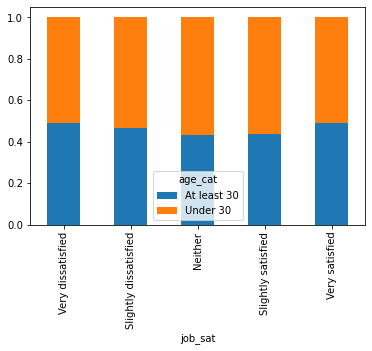

In [18]:
# EDA: proportional stacked bar plot
props = stack_overflow.groupby('job_sat')['age_cat'].value_counts(normalize=True) # proportion of age_cat grouped by job_sat
wide_props = props.unstack() # unstack the result to be in wide format instead of long
wide_props.plot(kind='bar', stacked=True)

In [19]:
# chi2 of age_cat vs. job_sat
expected, observed, stats = pingouin.chi2_independence(data=stack_overflow, 
                                                       x='job_sat', 
                                                       y='age_cat',
                                                       correction=False)
stats

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.000000,5.552373,4.0,0.235164,0.049555,0.437417
1,cressie-read,0.666667,5.554106,4.0,0.235014,0.049563,0.437545
2,log-likelihood,0.000000,5.558529,4.0,0.234632,0.049583,0.437871
3,freeman-tukey,-0.500000,5.562688,4.0,0.234274,0.049601,0.438178
4,mod-log-likelihood,-1.000000,5.567570,4.0,0.233854,0.049623,0.438538
5,neyman,-2.000000,5.579519,4.0,0.232828,0.049676,0.439419


> <i>correction</i>: specifies whether or not to apply Yate's continuity correction, typically applied when the sample size is small and degrees of freedom is 1. In this case since each group has relatively large records, we don't need it here

> $dof = (No. of\ response\ categories - 1) * (No. of\ explanatory\ categories - 1)$
<br>= (2-1) * (5-1) = 4

#### Swap the repsonse and explanatory variables

<AxesSubplot:xlabel='age_cat'>

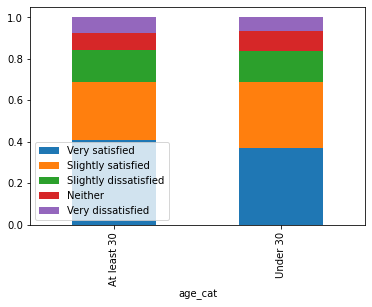

In [20]:
# EDA 
props = stack_overflow.groupby('age_cat')['job_sat'].value_counts(normalize=True)
wide_props = props.unstack()
wide_props.plot(kind='bar', stacked=True)

In [21]:
# chi2 of job_sat vs. age_cat
expected, observed, stats = pingouin.chi2_independence(data=stack_overflow, 
                                                       x='age_cat', 
                                                       y='job_sat')
stats[stats['test']=='pearson']

,test,lambda,chi2,dof,pval,cramer,power
0,pearson,1.0,5.552373,4.0,0.235164,0.049555,0.437417


> After swapping variables, the stats of chi2 test is <b>identical</b>
><br> So we should rephrase the question as: <b>are the variables X and Y independent?</b> since the order doesn't matter

## Goodness of fit test (one-sample Chi-square test)

In [22]:
purple_link_counts = stack_overflow['purple_link'].value_counts()
purple_link_counts = purple_link_counts.rename_axis('purple_link').reset_index(name='n')
purple_link_counts

,purple_link,n
0,"Hello, old friend",1225
1,Indifferent,405
2,Amused,368
3,Annoyed,263


In [23]:
hypothesized = pd.DataFrame({'purple_link': ['Hello, old friend', 'Amused', 'Indifferent', 'Annoyed'],
                            'prop': [1/2, 1/6, 1/6, 1/6]})
hypothesized['n'] = hypothesized['prop']*len(stack_overflow)
hypothesized

,purple_link,prop,n
0,"Hello, old friend",0.500000,1130.500000
1,Amused,0.166667,376.833333
2,Indifferent,0.166667,376.833333
3,Annoyed,0.166667,376.833333


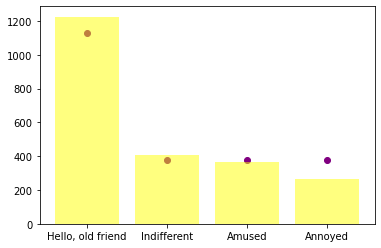

In [24]:
# EDA
plt.bar(purple_link_counts['purple_link'], purple_link_counts['n'], color="yellow", alpha=0.5)
plt.scatter(hypothesized['purple_link'], hypothesized['n'], color="purple")
plt.show()

In [25]:
# Goodness of fit test
gof_test = chisquare(f_obs = purple_link_counts['n'], f_exp=hypothesized['n']) # alpha=0.01
print(gof_test)

Power_divergenceResult(statistic=44.59840778416629, pvalue=1.1261810719413759e-09)


> The p-value is much smaller than significance level, so the sample distribution of proportions is different from the hypothesized distribution of proportions

## Wilcoxon-Mann-Whitney test (Mann Whitney U test)

In [26]:
age_vs_comp = stack_overflow[['converted_comp', 'age_first_code_cut']]
age_vs_comp.head()

,converted_comp,age_first_code_cut
0,77556.0,adult
1,74970.0,child
2,594539.0,child
3,2000000.0,adult
4,37816.0,adult


In [27]:
# Convert df from long to wide
age_vs_comp_wide = age_vs_comp.pivot(columns='age_first_code_cut',
                                     values='converted_comp')
age_vs_comp_wide.head()

age_first_code_cut,adult,child
0,77556.0,NaN
1,NaN,74970.0
2,NaN,594539.0
3,2000000.0,NaN
4,37816.0,NaN


In [28]:
alpha = 0.01
mwu_test = pingouin.mwu(x=age_vs_comp_wide['child'],
                        y=age_vs_comp_wide['adult'],
                        alternative='greater')
mwu_test

,U-val,alternative,p-val,RBC,CLES
MWU,744365.5,greater,1.902723e-19,-0.222516,0.611258


In [29]:
print(f"Reject null hypothesis? {mwu_test['p-val'][0]<alpha}")

Reject null hypothesis? True


## Kruskal-Wallis test

In [30]:
alpha = 0.01
kruskal_test = pingouin.kruskal(data=stack_overflow,
                                dv='converted_comp',
                                between='job_sat')
kruskal_test

,Source,ddof1,H,p-unc
Kruskal,job_sat,4,72.814939,5.772915e-15


In [31]:
print(f"At least one of the mean compensation totals is different than the others across job satisfaction groups? {kruskal_test['p-unc'][0]<alpha}")

At least one of the mean compensation totals is different than the others across job satisfaction groups? True
